# LLaVA-NeXT Inference for Dataextraction on Invoices

[Documentation on Hugging Face](https://huggingface.co/docs/transformers/v4.51.3/en/model_doc/llava_next#multi-image-inference)

[Model Card](https://huggingface.co/llava-hf/llava-v1.6-mistral-7b-hf)

[Homepage](https://llava-vl.github.io/blog/2024-01-30-llava-next/)

## Preparation

First we'll set some variables to work with LLaVA-NeXT locally. loading_model_from_hub needs to be set to true, when running the notebook for the first time to download the model from the hub. For following runs, it can be set to false to work with locally saved model and processor.

You can set load_in_8bit to load the model in 8bit quantization to fit on GPU if you face memory constraints, but need performance. Otherwise if it doesn't git in GPU memory, parts will be offloaded to CPU. I was not experiencing any significant difference in output quality when using 8bit.

In [1]:
dataset_id = "Aoschu/donut_model_data_for_german_invoice"
model_id = "llava-hf/llava-v1.6-mistral-7b-hf"

local_proc_repo = "llava-processor"
local_model_repo = "llava"
output_filename = "llava_next_output_ds2_8bit.json"

loading_model_from_hub = False
loading_ds_from_hub = False

load_in_8bit = True

Let's load the dataset from the hub. You might want to implement saving to disk in case you are using a larger dataset. Here we are interested in the test split, so let's have a look at that.

In [2]:
from datasets import load_dataset, load_from_disk

if loading_ds_from_hub:
    dataset = load_dataset(dataset_id)
    test_split = dataset["test"]

    test_split
    test_split.save_to_disk("ds2_test")

test_split = load_from_disk("ds2_test")

Let's check out an example.

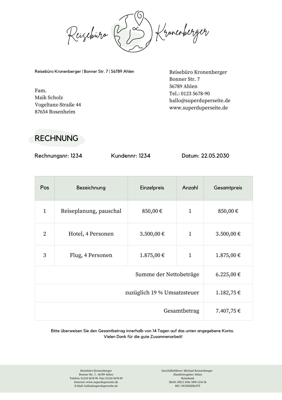

In [3]:
example = test_split[0]
image = example["image"]
width, height = image.size
display(image.resize((int(width*0.2), int(height*0.2))))

In [4]:
example["ground_truth"]

'{"gt_parse": {"Der Name der Firma": "Reisebiiro Kronenberger", "Die Adresse der Firma": "Bonner Str. 756789 Ahlen", "Telefonnummer": "01234 5678-90", "Rechnungsdatum": ": 22.05.2030", "Summe": "7.407,75", "IBAN": "DE12 3456 7890 1234 56", "Der Name der Bank": "Reisebank"}}'

Or in more human readable form:

In [5]:
from ast import literal_eval

literal_eval(example["ground_truth"])

{'gt_parse': {'Der Name der Firma': 'Reisebiiro Kronenberger',
  'Die Adresse der Firma': 'Bonner Str. 756789 Ahlen',
  'Telefonnummer': '01234 5678-90',
  'Rechnungsdatum': ': 22.05.2030',
  'Summe': '7.407,75',
  'IBAN': 'DE12 3456 7890 1234 56',
  'Der Name der Bank': 'Reisebank'}}

Since, the image and ground truth look good, we continue to load the model. If we do this for the first time, we load it from the hub and save it to disk.

float16 dtype is recommended for LLaVA, but quantization to 8bit might be necessary to fit on GPU.

In [6]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

if loading_model_from_hub:
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForImageTextToText.from_pretrained(model_id)
    processor.save_pretrained(local_proc_repo)
    model.save_pretrained(local_model_repo)


processor = AutoProcessor.from_pretrained(local_proc_repo)


if load_in_8bit:
    quantization_config = BitsAndBytesConfig(
        load_in_8bit=True
    )
    model = AutoModelForImageTextToText.from_pretrained(
        local_model_repo,
        quantization_config=quantization_config,
        device_map="auto"
    )
else:
    model = AutoModelForImageTextToText.from_pretrained(
    local_model_repo,
    torch_dtype=torch.float16,
    device_map="auto"
    )

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

## Inference

This is where the actual generation of output is done. The text input (prompt) is the same for every image.

In [7]:
outputs = []
for i, data in enumerate(test_split):
    image = data["image"]

    message = [{
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": 'Extract all key information from the document and return it as JSON. Separate decimal places by comma for all values. Use the following format and do not add additional fields: {"Der Name der Firma": {company name}, "Die Adresse der Firma": {company address}, "Telefonnummer": {phone number}, "Rechnungsdatum": {invoice date}, "Summe": {total gross sum}, "IBAN": {bank account iban}, "Der Name der Bank": {name of the bank}}}.' },
            ]
        }]

    prompt = processor.apply_chat_template(message, add_generation_prompt=True)
    inputs = processor(text=prompt, images=image, padding=True, return_tensors="pt").to(model.device)
    generated_ids = model.generate(**inputs, max_new_tokens=4096)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    outputs.append(generated_texts)
    print(f"Processed item {i + 1}/{len(test_split)}")

print("Inference loop finished.")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 1/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 2/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 3/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 4/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 5/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 6/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 7/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 8/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 9/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 10/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 11/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 12/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 13/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 14/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 15/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 16/18


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed item 17/18
Processed item 18/18
Inference loop finished.


Let's have a look at the output format for the first 3 examples.

In [8]:
outputs[:3]

[['[INST]  \nExtract all key information from the document and return it as JSON. Separate decimal places by comma for all values. Use the following format and do not add additional fields: {"Der Name der Firma": {company name}, "Die Adresse der Firma": {company address}, "Telefonnummer": {phone number}, "Rechnungsdatum": {invoice date}, "Summe": {total gross sum}, "IBAN": {bank account iban}, "Der Name der Bank": {name of the bank}}}. [/INST] ```json\n{\n  "Der Name der Firma": "Reisebüro Kronenberger",\n  "Die Adresse der Firma": "Reisbüro Kronenberger Bonner Str. 5799 Alten",\n  "Telefonnummer": "Tel.: 0221 567890",\n  "Rechnungsdatum": "22.05.2030",\n  "Summe": "1,875.00 EUR",\n  "IBAN": "DE89 000 000 000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0

Let's have another look, this time in more human readable form.

In [9]:
formatted_texts = []
# Iterate through the outputs and format each output
for output in outputs:
    formatted_text = '\n'.join(output)
    formatted_texts.append(formatted_text.replace('\\n', '<br>'))
for i, formatted_text in enumerate(formatted_texts[:3]):
    print(f"Output {i+1}:")
    print(formatted_text)
    print()

Output 1:
[INST]  
Extract all key information from the document and return it as JSON. Separate decimal places by comma for all values. Use the following format and do not add additional fields: {"Der Name der Firma": {company name}, "Die Adresse der Firma": {company address}, "Telefonnummer": {phone number}, "Rechnungsdatum": {invoice date}, "Summe": {total gross sum}, "IBAN": {bank account iban}, "Der Name der Bank": {name of the bank}}}. [/INST] ```json
{
  "Der Name der Firma": "Reisebüro Kronenberger",
  "Die Adresse der Firma": "Reisbüro Kronenberger Bonner Str. 5799 Alten",
  "Telefonnummer": "Tel.: 0221 567890",
  "Rechnungsdatum": "22.05.2030",
  "Summe": "1,875.00 EUR",
  "IBAN": "DE89 000 000 000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 00

These outputs can be saved to disk for further processing.

In [10]:
import json

try:
    with open(output_filename, 'w') as file:
        json.dump(outputs, file, indent=4)
    print(f"List successfully saved to {output_filename}")
except TypeError as e:
     print(f"Error saving list: {e}. JSON might not support all object types in the list.")
except Exception as e:
    print(f"Error saving list: {e}")

List successfully saved to llava_next_output_ds2_8bit.json


## Evaluation

We can load the outputs from disk again, if we decide to come back to this later.

In [11]:
import json

loading_outputs_from_disk = True

if loading_outputs_from_disk:
    outputs = None
    try:
        with open(output_filename, 'r') as file:
            outputs = json.load(file)
        print(f"List successfully loaded from {output_filename}")
    except FileNotFoundError:
        print(f"Error: File {output_filename} not found.")
    except json.JSONDecodeError as e:
        print(f"Error loading list: Invalid JSON format - {e}")
    except Exception as e:
        print(f"Error loading list: {e}")

List successfully loaded from llava_next_output_ds2_8bit.json


We also need the ground truths for evaluation. We'll have a look at the first 3.

In [12]:
from datasets import load_dataset, load_from_disk

test_split = load_from_disk("ds2_test")

ground_truth_list = []
for data_item in test_split:

    gt_string = data_item["ground_truth"]
    parsed_data = json.loads(gt_string)

    inner_dict = parsed_data["gt_parse"]

    ground_truth_list.append(inner_dict)

ground_truth_list[:3]

[{'Der Name der Firma': 'Reisebiiro Kronenberger',
  'Die Adresse der Firma': 'Bonner Str. 756789 Ahlen',
  'Telefonnummer': '01234 5678-90',
  'Rechnungsdatum': ': 22.05.2030',
  'Summe': '7.407,75',
  'IBAN': 'DE12 3456 7890 1234 56',
  'Der Name der Bank': 'Reisebank'},
 {'Der Name der Firma': 'Werbeagentur Kluger,',
  'Rechnungsnummer': '01234',
  'Rechnungsdatum': '13.08.2024',
  'Falligkeitsdatum': '15.09.2024',
  'Die Adresse der Firma': 'Jede StraBe 123, 12345 Jede Stadt',
  'Summe': '2142,00 €',
  'Telefonnummer': '(0221) 1234-56',
  'IBAN': '0123 4567 8901'},
 {'Die Adresse der Firma': 'asso | 12 rset',
  'Rechnungsnummer': '12345',
  'Summe': '1.332,80',
  'Telefonnummer': '{+49} 1234/98 7654'}]

From those ground truths we'll extract the keys for the key value pairs. Notice that we do this only by looking at the first example, assuming the ground truth data is structured the same for all rows.

In [13]:
keys = set()

if 'ground_truth_list' in locals() and isinstance(ground_truth_list, list):
    for item in ground_truth_list:
        if isinstance(item, dict):
            # Add top-level keys
            keys.update(item.keys())
            # Check values for nested structures
            for value in item.values():
                if isinstance(value, dict):
                    # Add keys from nested dictionary
                    keys.update(value.keys())
                elif isinstance(value, list):
                     # If value is a list, check items within it
                     for element_in_list in value:
                         if isinstance(element_in_list, dict):
                             # Add keys from dictionary inside the list
                             keys.update(element_in_list.keys())

    print("All unique keys found (including nested & in lists):", sorted(list(keys)))

else:
    print("'ground_truth_list' not found or not a list.")



All unique keys found (including nested & in lists): ['Der Name der Bank', 'Der Name der Firma', 'Die Adresse der Firma', 'Falligkeitsdatum', 'IBAN', 'Rechnungsdatum', 'Rechnungsnummer', 'Summe', 'Telefonnummer']


Now we can extract the actual fields of interest so we can evaluate them against the ground truths. Again, we'll have a look at the first 3 of them.

In [14]:
import re
import json

def get_empty_structure():
    """Returns a fresh copy of the desired JSON structure filled with empty strings."""
    return {
        k: '' for k in keys
    }

def extract_values_robustly(data_list):
    """
    Extracts values by searching for "key": "value" patterns for known keys
    in the raw model output string. Fills a predefined structure.
    """
    parsed_results = []

    for extracted_data in data_list:
        # Basic check for expected format (list containing at least one string)
        if not isinstance(extracted_data, list) or len(extracted_data) == 0 or not isinstance(extracted_data[0], str):
            print(f"Skipping item with unexpected format: {extracted_data}")
            continue
        full_string = extracted_data[0]

        # Start with a clean, empty structure for this output data
        result_structure = get_empty_structure()

        # Iterate through all the keys for summary and header
        for key in keys:
            pattern = r'"{key}":\s*"(.*?)"'.format(key=re.escape(key))

            # Search for the first occurrence of this pattern in the string
            match = re.search(pattern, full_string)

            if match:
                # If found, extract the value (captured group 1)
                value = match.group(1)
                result_structure[key] = value
                # If no match, the key's value remains the default empty string ''

        # Add the populated (or partially populated) structure to our results
        parsed_results.append(result_structure)


    return parsed_results

# --- Execution part ---
# Make sure the 'outputs' variable contains your list of model predictions
if 'outputs' in locals() and isinstance(outputs, list) and len(outputs) > 0:
    parsed_results = extract_values_robustly(outputs)
    print(f"\n--- Parsed Results ({len(parsed_results)} items processed) ---")

     # Print the results to verify
    for i, result in enumerate(parsed_results[:3]):
        print(f"\nResult {i+1}:")
        print(json.dumps(result, indent=4))

else:
    print("Variable 'outputs' not found, is not a list, or is empty. Cannot parse.")
    parsed_results = [] # Initialize empty list


--- Parsed Results (18 items processed) ---

Result 1:
{
    "Telefonnummer": "Tel.: 0221 567890",
    "Der Name der Firma": "Reiseb\u00fcro Kronenberger",
    "Die Adresse der Firma": "Reisb\u00fcro Kronenberger Bonner Str. 5799 Alten",
    "IBAN": "",
    "Summe": "1,875.00 EUR",
    "Rechnungsdatum": "22.05.2030",
    "Der Name der Bank": "",
    "Rechnungsnummer": "",
    "Falligkeitsdatum": ""
}

Result 2:
{
    "Telefonnummer": "1234 567890",
    "Der Name der Firma": "Karin Brahms",
    "Die Adresse der Firma": "Jede Strasse 123, 1234 Jede Stadt",
    "IBAN": "",
    "Summe": "2142.00 \u20ac",
    "Rechnungsdatum": "15.08.2024",
    "Der Name der Bank": "",
    "Rechnungsnummer": "",
    "Falligkeitsdatum": ""
}

Result 3:
{
    "Telefonnummer": "1234567890",
    "Der Name der Firma": "Kunden GmbH & Co. KG",
    "Die Adresse der Firma": "Hair Max Mustermann",
    "IBAN": "DE89 000 000 000 0000 000",
    "Summe": "1,000.00",
    "Rechnungsdatum": "2023-03-28",
    "Der Name der 

Now we can calculate some metrics.

Notice that Precision, recall and F1-score are typically used for classification problems, not text prediction or matching key value paris. In the context of matching key value pairs, incorrect predictions are counted both as false positive and false negative.

I've also calculated the accuracy based on the normalized tree edit distance by using the [donut-python](https://pypi.org/project/donut-python/) library. The main difference here is that, while the metrics are only counting fully correct or false predicitons per field, the three edit distance also measures how "close" any given predicitons was. You might want to implement this yourself or use another library, but I simply used it because I was comparing different models, including DONUT and so this seemed to be an easy way for an an additional baseline. I've also used the donut-python library to get the f1 score which was not consistent with my own implementation in this case.

For predictions with matching keys, I've also calculated the values word error rate as i[mplemented by the torcheval library](https://pytorch.org/torcheval/main/generated/torcheval.metrics.WordErrorRate.html#torcheval.metrics.WordErrorRate).

In [61]:
from collections.abc import Mapping, Sequence # Used for type checking in flatten function
from donut import JSONParseEvaluator # The Donut JSONParseEvaluator is used for here for better comparison of the two models
import numpy as np
from torcheval.metrics import WordErrorRate

def flatten_dict(d, parent_key='', sep='.'):
    items = {}
    for k, v in d.items() if isinstance(d, Mapping) else enumerate(d):
        new_key = f"{parent_key}{sep}{k}" if parent_key else str(k)
        if isinstance(v, Mapping):
            # If the value is a dictionary, recurse
            items.update(flatten_dict(v, new_key, sep=sep))
        elif isinstance(v, Sequence) and not isinstance(v, (str, bytes)):
            # If the value is a list/tuple (but not string/bytes), recurse
             items.update(flatten_dict(v, new_key, sep=sep))
        else:
            # It's a leaf value
            items[new_key] = v
    return items

def calculate_extraction_metrics(predictions, ground_truths):

    if len(predictions) != len(ground_truths):
        print("Error: Predictions and ground truths lists must have the same length.")
        return None

    total_tp = 0  # True Positives (field correctly extracted with correct value)
    total_fp = 0  # False Positives (field extracted but shouldn't be, or wrong value)
    total_fn = 0  # False Negatives (field should have been extracted but wasn't, or wrong value)
    accs = []
    total_fields = 0
    word_error_metric = WordErrorRate()

    for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
        # Field-Level Metrics (Precision, Recall, F1)
        flat_pred = flatten_dict(pred)
        flat_truth = flatten_dict(truth)

        # Convert to sets of (key, value) tuples for comparison
        pred_items = set(flat_pred.items())
        truth_items = set(flat_truth.items())

        def filter_empty_values(data):
            return [item for item in data if item[1]]

        non_empty_pred_items = set(filter_empty_values(pred_items))

        tp = len(pred_items.intersection(truth_items))
        fp = len(non_empty_pred_items.difference(truth_items))
        fn = len(truth_items.difference(pred_items))

        total_fields += len(flat_truth)
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
        evaluator = JSONParseEvaluator()
        acc_score = evaluator.cal_acc(pred, truth)
        accs.append(float(acc_score))

        def get_word_error_rate(input, target):
            for input_item in input:
                for target_item in target:
                    if input_item[0] == target_item[0]:
                        word_error_metric.update(input_item[1], target_item[1])

        get_word_error_rate(pred_items, truth_items)


        # Log TP, FP, FN for the a single dataset item
        log_item_details = 100 # Set number of item you want to log
        if i == log_item_details:
            print(f"Details for the dataset item no. {log_item_details+1}:\n")
            print("  True Positives:")
            for item in pred_items.intersection(truth_items):
                print(f"    {item}")

            print("\n  False Positives:")
            for item in non_empty_pred_items.difference(truth_items):
                print(f"    {item}")

            print("\n  False Negatives:")
            for item in truth_items.difference(pred_items):
                print(f"    {item}")
            print("\n")

    # Micro-average Precision, Recall, F1
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    mean_accuracy = np.mean(accs)
    f1_eval = evaluator.cal_f1(predictions, ground_truths)
    word_error_rate = word_error_metric.compute()

    return {
        "precision": precision,
        "recall": recall, 
        "f1_score": f1,
        "f1_eval": f1_eval,
        "mean_accuracy": mean_accuracy,
        "total_tp": total_tp,
        "total_fields": total_fields,
        "word_error_rate": word_error_rate,   
    }

# Calculate and Print Metrics
if parsed_results and ground_truth_list:
    metrics = calculate_extraction_metrics(parsed_results, ground_truth_list)
    print(f"Parsed {len(ground_truth_list)} items with a total of {metrics['total_fields']} fields to predict.")
    print()
    if metrics:
        print("Validation Metrics:")
        print(f"  Total True Positives:             {metrics['total_tp']}")
        print(f"  Precision:                        {metrics['precision']:.4f}")
        print(f"  Recall:                           {metrics['recall']:.4f}")
        print(f"  F1-Score (manual score):          {metrics['f1_score']:.4f}")
        print(f"  F1-Score (evaluator):             {metrics['f1_eval']:.4f}")
        print(f"  Accuracy (Tree Edit Distance):    {metrics['mean_accuracy']:.4f}")
        print(f"  Word Error Rate:                  {metrics['word_error_rate']:.4f}")

else:
    print("No valid lists provided for predictions and/or ground truths.")

Parsed 18 items with a total of 113 fields to predict.

Validation Metrics:
  Total True Positives:             9
  Precision:                        0.0849
  Recall:                           0.0796
  F1-Score (manual score):          0.0822
  F1-Score (evaluator):             0.0822
  Accuracy (Tree Edit Distance):    0.2191
  Word Error Rate:                  0.9721
